# CNN을 활용하여 고양이와 강아지 사진 분류하기
## 1. 데이터 준비하기
- 컴퓨터 비전 작업에 가장 널리 사용되는 CNN(Convolution Neural Network)를 활용하여 입력된 데이터가 고양이 또는 강아지인지 분류하는 모델을 설계하고 훈련한다.
- 기존에 Kaggle에서 진행했던 대회에 사용된 데이터를 일부 사용하여 진행할 예정이다.
- 데이터 다운로드 링크: https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import os, shutil

original_dataset_dir = '../datasets/train'

base_dir = '../datasets/small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [2]:
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## 2. 모델 구성 및 훈련
- 고양이와 강아지 사진들 중 각각 1000개의 훈련 데이터와 500개의 검증 데이터 그리고 500개의 테스트 데이터를 따로 추출했다.
- Conv2D 층과 MaxPooling2D 층을 연속적으로 배치하고 이진 분류를 위해 Flatten 층으로 데이터를 펼친 뒤 sigmoid 활성화 함수를 적용한 층을 마지막에 배치한다. 

In [2]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

- MaxPooling2D 층은 최대 풀링 연산을 통해 합성곱 층의 특성 맵을 강제로 다운샘플링하여 가중치 파라미터의 개수를 줄여 overfitting을 제한하는 역할을 한다.
- 또한 풀링 연산 과정에서 전체 입력 사이즈 대비 상대적으로 더 큰 사이즈의 윈도우로 관찰할 수 있게끔 한다.

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

- 이진 분류 문제이므로 손실 함수로 binary_crossentropy를 사용하고, 평가 척도로는 정확도를 선택한다.

In [4]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

- 이미지 데이터는 바로 케라스 텐서 연산에 입력할 수 없으므로, ImageDataGenerator를 이용하여 디스크에 있는 이미지를 입력 층에 알맞는 사이즤의 텐서들의 배치들로 변환해주는 generator를 만든다.
- ImageDataGenerator의 flow_from_directory 메소드를 이용하면 디렉토리에 따라 자동으로 클래스를 분류하여 라벨을 생성해준다. 이때 이진 분류이므로 class_mode는 binary로 설정한다.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [7]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
verbose=1)

Epoch 1/30
100/100 [==============================] - 37s 295ms/step - loss: 0.6849 - acc: 0.5585 - val_loss: 0.6526 - val_acc: 0.6380
Epoch 2/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6146 - acc: 0.6725 - val_loss: 0.6392 - val_acc: 0.6300
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5540 - acc: 0.7270 - val_loss: 0.5823 - val_acc: 0.6980
Epoch 4/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5122 - acc: 0.7480 - val_loss: 0.5594 - val_acc: 0.7230
Epoch 5/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4686 - acc: 0.7780 - val_loss: 0.5852 - val_acc: 0.6990
Epoch 6/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4322 - acc: 0.7940 - val_loss: 0.5530 - val_acc: 0.7340
Epoch 7/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4072 - acc: 0.8175 - val_loss: 0.5634 - val_acc: 0.7250
Epoch 8/30
100/100 [==============================] - 9s 92ms/step 

In [9]:
import numpy as np

def save_model(model, history, num=1):
    model.save('cats_and_dogs_small_%d.h5' % num)
    np.save('cats_and_dogs_history_%d.npy' % num,history.history)

- 모델을 훈련한 후 가중치가 업데이트된 모델과 훈련 기록을 담은 history를 저장한다.
- 훈련 결과 검증 정확도가 약 73% 이다.

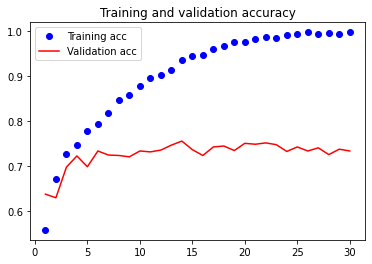

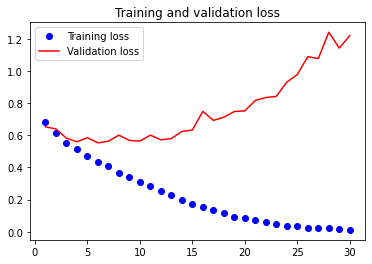

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3. 데이터 증식을 통한 Overfitting 억제
- 훈련 결과를 살펴보면 훈련 샘플이 너무 적어 훈련 데이터에 대한 overfitting이 꽤 심하게 나타나고 있다는 것을 알 수 있다.
- 기존 데이터로부터 데이터를 새로 증식하여 더 많은 훈련 데이터로 학습하는 것을 통해 더 일반화된 모델을 학습시킨다.

In [17]:
datagen = ImageDataGenerator( 
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

(1, 150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


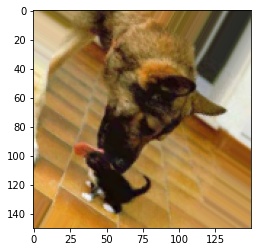

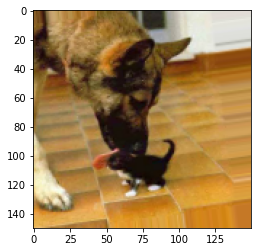

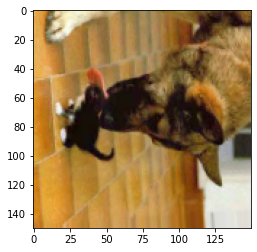

In [29]:
from tensorflow.keras.preprocessing import image
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

img_path = fnames[np.random.randint(0,len(fnames))]

img = image.load_img(img_path, target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    print(batch.shape)
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

- 새로운 모델을 구성하여 학습을 진행한다. 다만 overfitting을 억제하기 위해 Flatten 층 아래에 Dropout 층을 추가한다.
- 기존의 모델과 다르게 훈련 과정에서 데이터 증식을 활용하기 위해 훈련 데이터의 Generator가 데이터를 증식하도록 한다. 단, validation data와 test 데이터는 학습 과정에서 모델의 가중치를 업데이트 시키지 않으므로(테스트 용도이므로) 데이터를 증식시키지 않는다.

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary'
)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

save_model(model, history, 2)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 15s 143ms/step - loss: 0.6949 - acc: 0.4931 - val_loss: 0.6821 - val_acc: 0.5888
Epoch 2/100
100/100 [==============================] - 15s 150ms/step - loss: 0.6758 - acc: 0.5869 - val_loss: 0.7114 - val_acc: 0.5013
Epoch 3/100
100/100 [==============================] - 15s 151ms/step - loss: 0.6620 - acc: 0.5962 - val_loss: 0.6340 - val_acc: 0.6300
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.6532 - acc: 0.6187 - val_loss: 0.6355 - val_acc: 0.6200
Epoch 5/100
100/100 [==============================] - 15s 148ms/step - loss: 0.6373 - acc: 0.6294 - val_loss: 0.6377 - val_acc: 0.6400
Epoch 6/100
100/100 [==============================] - 14s 140ms/step - loss: 0.6129 - acc: 0.6806 - val_loss: 0.5917 - val_acc: 0.6675
Epoch 7/100
100/100 [==============================] - 14s 140ms/step - loss: 0.6037 - acc: 0.6712 -

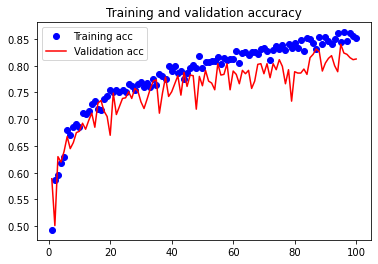

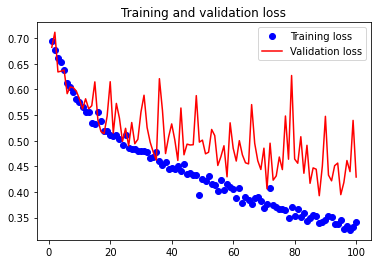

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 훈련 결과 훈련 데이터 증식을 사용하기 전보다 overfitting이 매우 억제된 것을 확인할 수 있었다.